In [211]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from tqdm import tqdm

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# parameters
batch_size = 32
epochs = 100
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_size = 0.7

lags = 12
forecast_horizon = 1



In [212]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 3GB'

In [213]:
# read data
data = pd.read_csv('../output-single/link_kpis_total_15min_intervals.csv',index_col=0)
data

,start_stop,end_stop,datetime,weighted_avg_headway,weighted_avg_speed,weighted_avg_time,no_of_trips
0,PF_A01_1,PF_B01_1,2024-01-29 10:00:00,12.408333,14.722512,1.414783,115.0
1,PF_A01_1,PF_B01_1,2024-01-29 10:15:00,10.592529,14.511484,1.426754,190.0
2,PF_A01_1,PF_B01_1,2024-01-29 10:30:00,11.185676,14.434930,1.437135,228.0
3,PF_A01_1,PF_B01_1,2024-01-29 10:45:00,13.865204,14.637638,1.423482,269.0
4,PF_A01_1,PF_B01_1,2024-01-29 11:00:00,10.505591,14.554157,1.429492,295.0
...,...,...,...,...,...,...,...
863193,PF_N12_C,PF_N11_C,2024-03-25 04:15:00,39.103261,22.816955,11.991667,46.0
863194,PF_N12_C,PF_N11_C,2024-03-25 04:30:00,23.964035,15.449527,11.529825,19.0
863195,PF_N12_C,PF_N11_C,2024-03-25 05:00:00,15.416667,6.409373,18.350000,1.0
863196,PF_N12_C,PF_N11_C,2024-03-25 05:15:00,21.955556,28.463462,8.588889,18.0


In [214]:
# convert to datetime and set as index
data.set_index('datetime', inplace=True)
data.index = pd.to_datetime(data.index)
data

,start_stop,end_stop,weighted_avg_headway,weighted_avg_speed,weighted_avg_time,no_of_trips
datetime,,,,,,
2024-01-29 10:00:00,PF_A01_1,PF_B01_1,12.408333,14.722512,1.414783,115.0
2024-01-29 10:15:00,PF_A01_1,PF_B01_1,10.592529,14.511484,1.426754,190.0
2024-01-29 10:30:00,PF_A01_1,PF_B01_1,11.185676,14.434930,1.437135,228.0
2024-01-29 10:45:00,PF_A01_1,PF_B01_1,13.865204,14.637638,1.423482,269.0
2024-01-29 11:00:00,PF_A01_1,PF_B01_1,10.505591,14.554157,1.429492,295.0
...,...,...,...,...,...,...
2024-03-25 04:15:00,PF_N12_C,PF_N11_C,39.103261,22.816955,11.991667,46.0
2024-03-25 04:30:00,PF_N12_C,PF_N11_C,23.964035,15.449527,11.529825,19.0
2024-03-25 05:00:00,PF_N12_C,PF_N11_C,15.416667,6.409373,18.350000,1.0


In [215]:
# filter by start stop and end stop
start_stop = 'PF_A02_C'
end_stop = 'PF_A01_1'

linkData = data[(data['start_stop'] == start_stop) & (data['end_stop'] == end_stop)]
linkData

,start_stop,end_stop,weighted_avg_headway,weighted_avg_speed,weighted_avg_time,no_of_trips
datetime,,,,,,
2024-01-29 10:00:00,PF_A02_C,PF_A01_1,12.054668,21.568098,2.112281,114.0
2024-01-29 10:15:00,PF_A02_C,PF_A01_1,10.592529,21.616313,2.107018,190.0
2024-01-29 10:30:00,PF_A02_C,PF_A01_1,11.184671,21.814639,2.096711,228.0
2024-01-29 10:45:00,PF_A02_C,PF_A01_1,13.862466,22.202748,2.078810,269.0
2024-01-29 11:00:00,PF_A02_C,PF_A01_1,10.510198,22.271370,2.065593,295.0
...,...,...,...,...,...,...
2024-03-25 04:00:00,PF_A02_C,PF_A01_1,17.487955,16.328915,5.482955,44.0
2024-03-25 04:15:00,PF_A02_C,PF_A01_1,15.688210,7.953485,11.365432,27.0
2024-03-25 04:30:00,PF_A02_C,PF_A01_1,12.215903,12.089271,13.704167,12.0


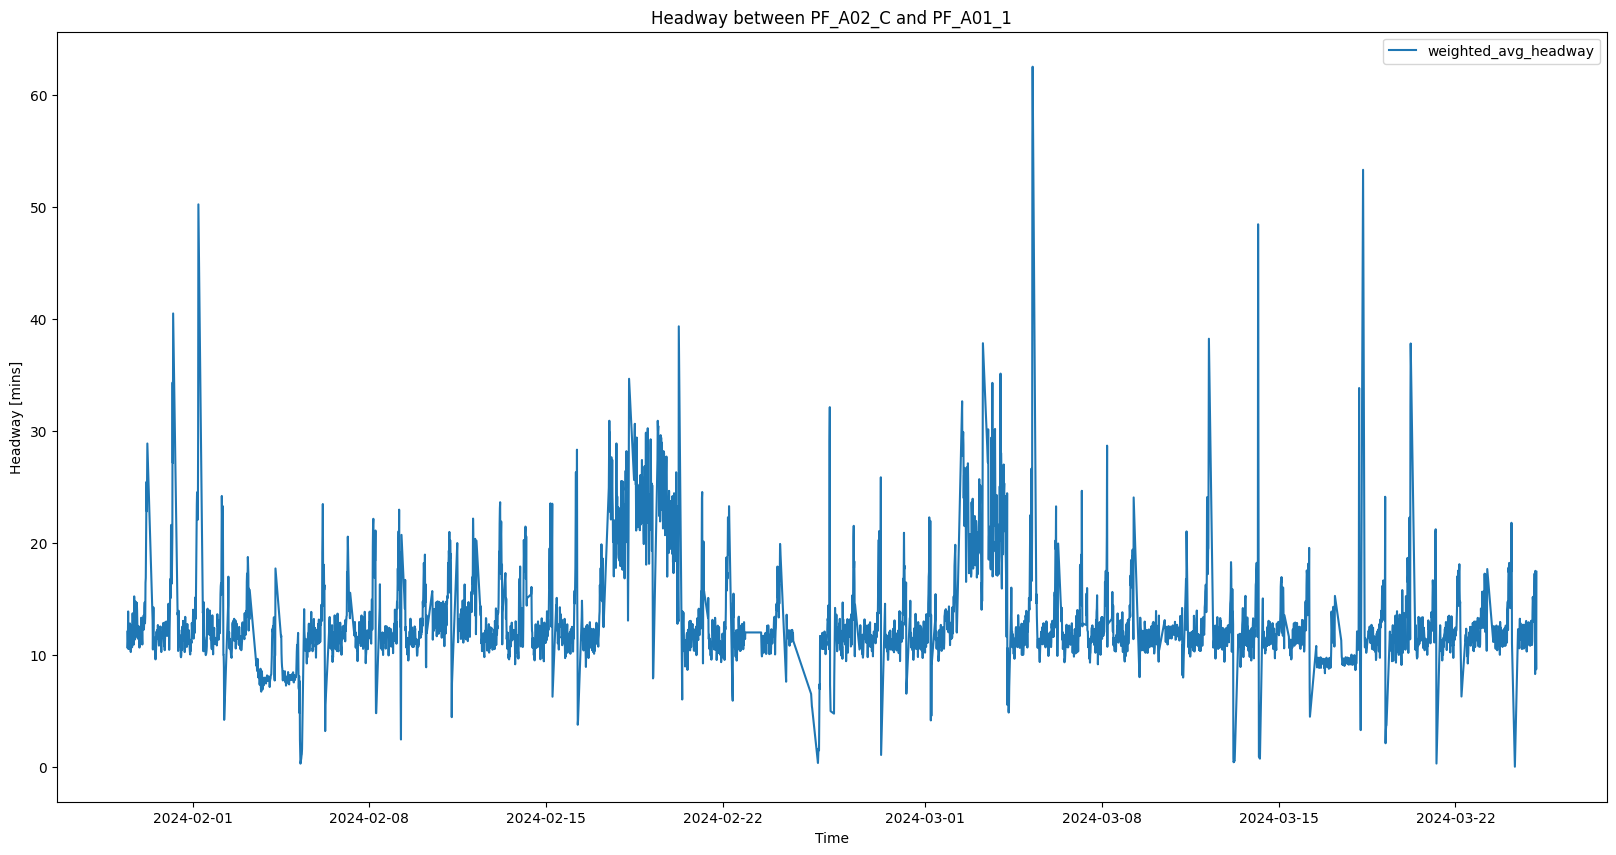

In [216]:
# plotting the data

plt.figure(figsize=(20,10))
plt.plot(linkData['weighted_avg_headway'], label='weighted_avg_headway')

plt.title('Headway between {} and {}'.format(start_stop, end_stop))
plt.xlabel('Time')
plt.ylabel('Headway [mins]')

plt.legend()
plt.show()

<Axes: ylabel='Frequency'>

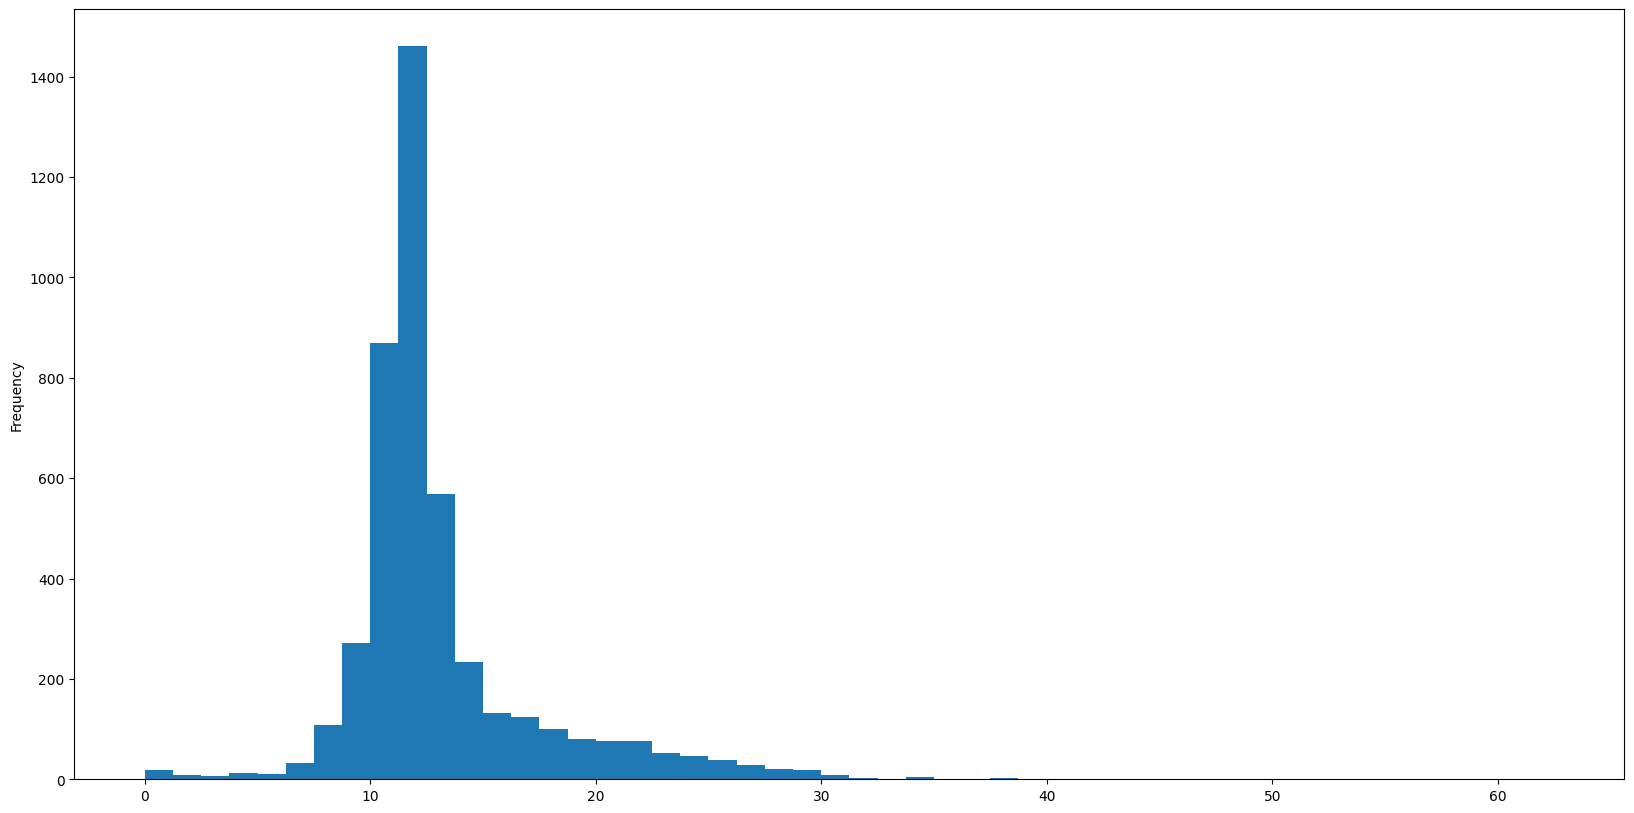

In [217]:
linkData['weighted_avg_headway'].plot(kind='hist', bins=50, figsize=(20,10))

In [218]:
linkData = linkData[['weighted_avg_headway']]
linkData

,weighted_avg_headway
datetime,
2024-01-29 10:00:00,12.054668
2024-01-29 10:15:00,10.592529
2024-01-29 10:30:00,11.184671
2024-01-29 10:45:00,13.862466
2024-01-29 11:00:00,10.510198
...,...
2024-03-25 04:00:00,17.487955
2024-03-25 04:15:00,15.688210
2024-03-25 04:30:00,12.215903


In [219]:
# creating the lags for the model
def create_lags(data, lags):
    data_lagged = dc(data)
    for i in range(1, lags+1):
        data_lagged['lag_{}'.format(i)] = data_lagged['weighted_avg_headway'].shift(i)
    
    data_lagged.dropna(inplace=True)
    
    return data_lagged

linkData_lagged = create_lags(linkData, lags)
linkData_lagged

,weighted_avg_headway,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,
2024-01-29 13:00:00,10.595700,11.237410,12.789670,11.690334,10.500134,10.719351,11.597952,11.235004,10.510198,13.862466,11.184671,10.592529,12.054668
2024-01-29 13:15:00,10.237539,10.595700,11.237410,12.789670,11.690334,10.500134,10.719351,11.597952,11.235004,10.510198,13.862466,11.184671,10.592529
2024-01-29 13:30:00,11.099399,10.237539,10.595700,11.237410,12.789670,11.690334,10.500134,10.719351,11.597952,11.235004,10.510198,13.862466,11.184671
2024-01-29 13:45:00,11.431629,11.099399,10.237539,10.595700,11.237410,12.789670,11.690334,10.500134,10.719351,11.597952,11.235004,10.510198,13.862466
2024-01-29 14:00:00,11.815977,11.431629,11.099399,10.237539,10.595700,11.237410,12.789670,11.690334,10.500134,10.719351,11.597952,11.235004,10.510198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25 04:00:00,17.487955,8.274296,14.168710,17.245788,16.083660,14.510000,15.238374,12.962157,14.054167,14.859447,15.137153,13.700521,11.208584
2024-03-25 04:15:00,15.688210,17.487955,8.274296,14.168710,17.245788,16.083660,14.510000,15.238374,12.962157,14.054167,14.859447,15.137153,13.700521
2024-03-25 04:30:00,12.215903,15.688210,17.487955,8.274296,14.168710,17.245788,16.083660,14.510000,15.238374,12.962157,14.054167,14.859447,15.137153


In [220]:
# convert to np array for scaling
data_np = linkData_lagged.to_numpy()
data_np

array([[10.59570036, 11.23741031, 12.78967017, ..., 11.18467068,
        10.59252897, 12.05466821],
       [10.23753899, 10.59570036, 11.23741031, ..., 13.86246647,
        11.18467068, 10.59252897],
       [11.09939946, 10.23753899, 10.59570036, ..., 10.51019829,
        13.86246647, 11.18467068],
       ...,
       [12.21590278, 15.68820988, 17.48795455, ..., 14.05416696,
        14.85944665, 15.13715317],
       [ 8.69416667, 12.21590278, 15.68820988, ..., 12.96215723,
        14.05416696, 14.85944665],
       [17.39871795,  8.69416667, 12.21590278, ..., 15.23837375,
        12.96215723, 14.05416696]], shape=(4412, 13))

In [221]:
# scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_np)

# creating test and train data
X = data_scaled[:, 1:]
X = dc(np.flip(X, axis=1))
y = data_scaled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# reahape the data
X_train = X_train.reshape(-1, lags, 1)
X_test = X_test.reshape(-1, lags, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# tensor conversion
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1323, 12, 1]),
 torch.Size([3089, 12, 1]),
 torch.Size([1323, 1]),
 torch.Size([3089, 1]))

In [222]:
# create the dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [223]:
# loading the data onto the device
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# looping through so that the data is in the gpu
for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)
    break

In [224]:
# # creating the model
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_stacked_layers):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
#                             batch_first=True)

#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # instantiate the model
# model = LSTM(input_size=1, hidden_size=4,num_stacked_layers=1).to(device)
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

In [225]:
class LSTM(nn.Module):
    """
    A bidirectional LSTM network for forecasting a given horizon.

    Args:
        input_size (int): Number of expected features in the input.
        hidden_size (int): Number of features in the hidden state.
        num_stacked_layers (int): Number of stacked LSTM layers.
        forecast_horizon (int): Number of time steps to forecast.
    """
    def __init__(self, input_size, hidden_size, num_stacked_layers, forecast_horizon):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.forecast_horizon = forecast_horizon

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        # Fully connected layer now outputs forecast_horizon predictions,
        # note the hidden state is doubled for bidirectionality.
        self.fc = nn.Linear(hidden_size * 2, forecast_horizon)
        self.bn = nn.BatchNorm1d(hidden_size * 2)

    def forward(self, x):
        """
        Forward propagation of the LSTM network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Forecast predictions of shape (batch_size, forecast_horizon).
        """
        batch_size = x.size(0)
        # Initialize hidden and cell states for bidirectional LSTM.
        h0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # use the last time-step output
        out = self.bn(out)
        out = self.fc(out)
        return out

# Instantiate the model with forecast_horizon.
model = LSTM(input_size=1, hidden_size=32, num_stacked_layers=2, forecast_horizon=forecast_horizon).to(device)
loss_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [226]:
# training the model
def train_one_epoch(epoch):
    model.train()  # set model to training mode
    running_loss = 0.0
    for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_mse(output, y_batch)/2
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.3f}')
    losses.append(avg_loss)

def validate_one_epoch(epoch):
    model.eval()  # set model to eval mode
    running_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_mse(output, y_batch)
            running_loss += loss.item()
    avg_loss = running_loss / len(test_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_loss:.3f}')
    print('***************************************************\n')

losses = []

for epoch in range(epochs):
    train_one_epoch(epoch)
    validate_one_epoch(epoch)
    # stop if loss is very low or percentage change in loss is below threshold
    if losses[-1] < 0.005:
        break
    if epoch > 0:
        percent_change = abs(losses[-2] - losses[-1]) / losses[-2]
        if percent_change < 0.001:
            print(f"Early stopping at epoch {epoch+1} due to low percentage change ({percent_change:.4f}) in loss")
            break


Training Epoch 1:  14%|█▍        | 6/42 [00:00<00:00, 58.25it/s]

Training Epoch 1: 100%|██████████| 42/42 [00:00<00:00, 64.80it/s]


Epoch 1, Training Loss: 0.156
Epoch 1, Validation Loss: 0.114
***************************************************



Training Epoch 2: 100%|██████████| 42/42 [00:00<00:00, 76.01it/s]


Epoch 2, Training Loss: 0.049
Epoch 2, Validation Loss: 0.019
***************************************************



Training Epoch 3: 100%|██████████| 42/42 [00:00<00:00, 95.11it/s]


Epoch 3, Training Loss: 0.013
Epoch 3, Validation Loss: 0.009
***************************************************



Training Epoch 4: 100%|██████████| 42/42 [00:00<00:00, 76.85it/s]


Epoch 4, Training Loss: 0.007
Epoch 4, Validation Loss: 0.012
***************************************************



Training Epoch 5: 100%|██████████| 42/42 [00:00<00:00, 99.66it/s] 


Epoch 5, Training Loss: 0.006
Epoch 5, Validation Loss: 0.011
***************************************************



Training Epoch 6: 100%|██████████| 42/42 [00:00<00:00, 83.52it/s]


Epoch 6, Training Loss: 0.006
Epoch 6, Validation Loss: 0.010
***************************************************



Training Epoch 7: 100%|██████████| 42/42 [00:00<00:00, 99.29it/s] 


Epoch 7, Training Loss: 0.005
Epoch 7, Validation Loss: 0.011
***************************************************



Training Epoch 8: 100%|██████████| 42/42 [00:00<00:00, 87.86it/s]


Epoch 8, Training Loss: 0.005
Epoch 8, Validation Loss: 0.016
***************************************************



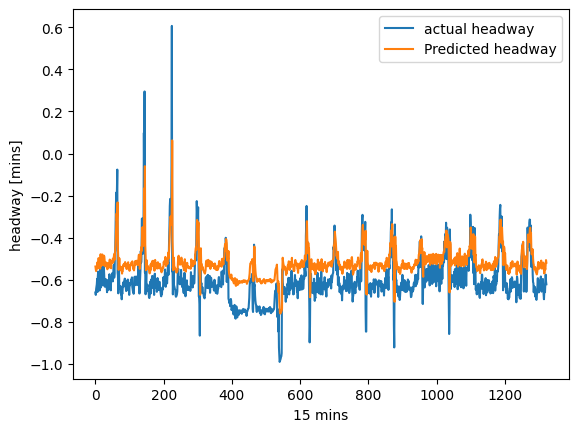

In [227]:
# plotting the predictions vs the actual values for the training data
with torch.no_grad():
    predicted_train = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='actual headway')
plt.plot(predicted_train, label='Predicted headway')
plt.xlabel('15 mins')
plt.ylabel('headway [mins]')
plt.legend()
plt.show()

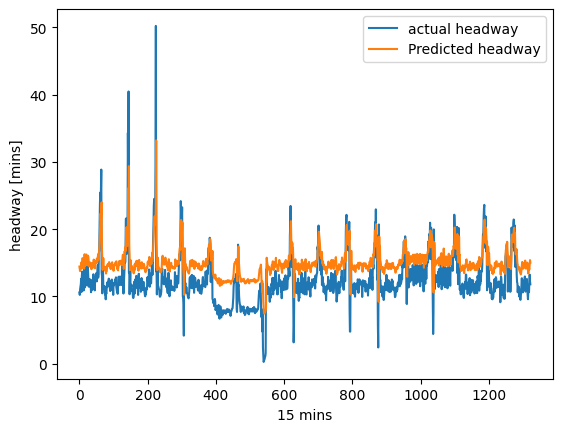

In [228]:
# rescale the data
# Since the scaler was fitted on 13 features, create dummy columns for the missing ones.
dummy_pred = np.zeros((predicted_train.shape[0], 12))
predicted_full = np.concatenate([predicted_train, dummy_pred], axis=1)
predicted_inverse = scaler.inverse_transform(predicted_full)[:, 0]

y_train_np = y_train.cpu().numpy() if torch.is_tensor(y_train) else y_train
dummy_y = np.zeros((y_train_np.shape[0], 12))
y_train_full = np.concatenate([y_train_np, dummy_y], axis=1)
y_train_inverse = scaler.inverse_transform(y_train_full)[:, 0]

plt.plot(y_train_inverse, label='actual headway')
plt.plot(predicted_inverse, label='Predicted headway')
plt.xlabel('15 mins')
plt.ylabel('headway [mins]')
plt.legend()
plt.show()

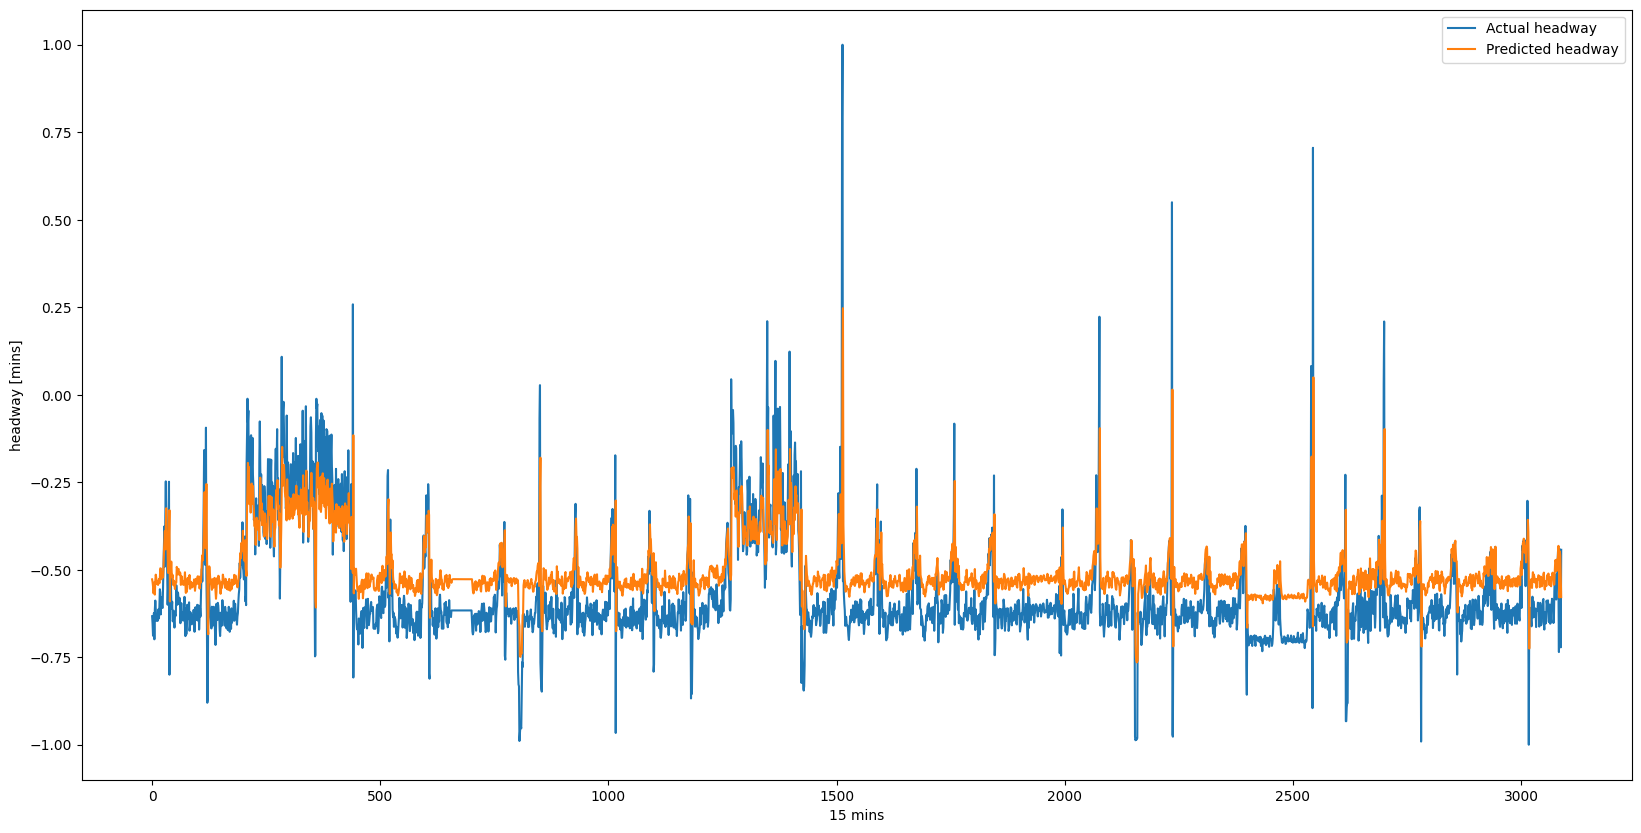

In [229]:
# plotting the predictions vs the actual values for the test data
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(y_test, label='Actual headway')
plt.plot(predicted_test, label='Predicted headway')
plt.xlabel('15 mins')
plt.ylabel('headway [mins]')
plt.legend()
plt.show()


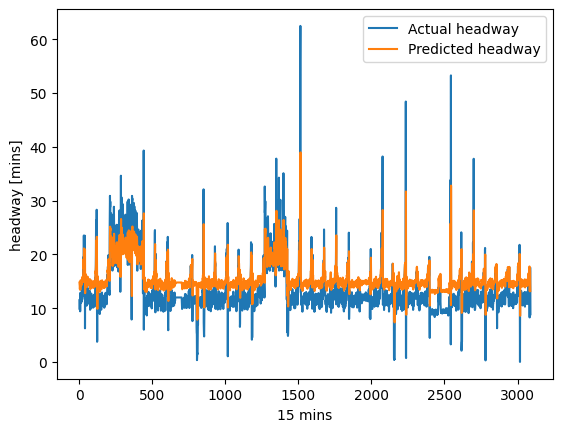

In [230]:
# rescale the data
dummy_pred = np.zeros((predicted_test.shape[0], 12))
predicted_full = np.concatenate([predicted_test, dummy_pred], axis=1)
predicted_inverse = scaler.inverse_transform(predicted_full)[:, 0]

y_test_np = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test
dummy_y = np.zeros((y_test_np.shape[0], 12))
y_test_full = np.concatenate([y_test_np, dummy_y], axis=1)
y_test_inverse = scaler.inverse_transform(y_test_full)[:, 0]

plt.plot(y_test_inverse, label='Actual headway')
plt.plot(predicted_inverse, label='Predicted headway')
plt.xlabel('15 mins')
plt.ylabel('headway [mins]')
plt.legend()
plt.show()

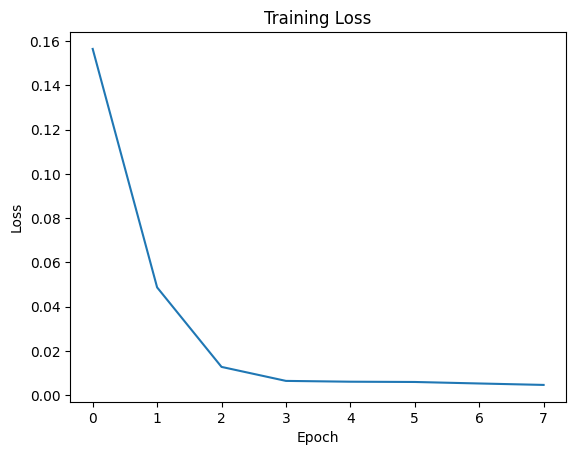

In [231]:
# plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()